In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [4]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print (len(df))

9779168


In [5]:
df = df[df['mo'].isin([1,2,3,12])] #  somente meses do verão DEZ a MAR
print (len(df))
df.sample(3)

3206856


,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
4444706,352,BURITIS,894.0,-15.524262,-46.435536,A544,Buritis,MG,2012-12-18 18:00:00,2012-12-18,...,32.5,15.0,30.6,9.4,32.0,37.0,25.0,1.3,230.0,5.9
6584238,381,TERESÓPOLIS,991.0,-22.448922,-42.987146,A618,Teresópolis,RJ,2013-03-17 22:00:00,2013-03-17,...,19.8,19.3,19.5,18.8,97.0,97.0,96.0,0.5,91.0,2.2
6826431,384,VILA MILITAR,30.0,-22.861322,-43.411410,A621,Rio de Janeiro,RJ,2013-03-14 07:00:00,2013-03-14,...,25.7,23.2,25.2,22.8,87.0,88.0,86.0,0.4,106.0,2.3


In [6]:
df = df.sort_values(['wsid', 'mdct'])
df = df.reset_index(drop=True)

In [7]:
#df = df[(df['lat'].between(-20.5,-19.0, inclusive=True)) & 
#        (df['lon'].between(-44.5,-43.0, inclusive=True))] 

In [8]:
df = df[df['wsid']==329]
print (len(df))

29112


In [9]:
df.head(4)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
816792,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-12-01 00:00:00,2006-12-01,...,20.7,20.5,20.4,20.2,99.0,99.0,98.0,1.0,121.0,2.6
816793,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-12-01 01:00:00,2006-12-01,...,20.9,20.6,20.7,20.5,98.0,99.0,98.0,1.2,146.0,2.0
816794,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-12-01 02:00:00,2006-12-01,...,20.9,20.6,20.5,20.3,98.0,98.0,98.0,0.5,309.0,2.0
816795,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-12-01 03:00:00,2006-12-01,...,20.7,20.5,20.6,20.3,98.0,98.0,98.0,NaN,356.0,0.9


# Pré-processamento

<h3>Dados ausentes</h3>

In [10]:
missing_values_count = (df.isnull().sum()/len(df))*100

In [11]:
missing_values_count[missing_values_count > 0.1]

prcp    86.723688
gbrd    41.872767
wdsp     5.021984
gust     1.329349
dtype: float64

<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [12]:
df = df.drop('gbrd',1)

<p>Para as precipitações nulas foi inputado 0.0 mm. Também para o vento e rajada de vento.</p>

In [13]:
CAN_BE_NULL = ['wdsp','prcp','gust']

In [14]:
for v in CAN_BE_NULL:
    df[v] = df[v].fillna(0.0)

In [15]:
missing_values_count = (df.isnull().sum()/len(df))*100
miss = missing_values_count[missing_values_count > 0]
miss

Series([], dtype: float64)

<p>Alguns campos estão com pouquissimos valores nulos.</p>

In [16]:
DES = ['wsid','wsnm','elvt','lat','lon','inme','city','prov','mdct','date','yr','mo','da','hr']

In [17]:
V = [x for x in df.columns if x not in DES]
#df[V].describe().T

<p><b>PRONTO! Dados recuperados!</b> Agora vamos a etapa de limpeza</p>

<h3>Limpeza dos dados</h3>

In [18]:
backup_df = df.copy

<p>Alguns campos podem ser nulos</p>

In [19]:
cols = list(df.columns)

COLS_BE_NULL = ['prcp','wdsp','gust'] + DES
for v in COLS_BE_NULL:
    if v in cols:
        cols.remove(v)
cols

['stp',
 'smax',
 'smin',
 'temp',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdct']

In [20]:
df[V].describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,29112.0,0.380702,2.269639,0.0,0.0,0.0,0.0,78.4
stp,29112.0,908.517257,89.239876,0.0,915.8,917.4,918.9,924.2
smax,29112.0,908.700110,89.580653,0.0,916.0,917.7,919.1,924.3
smin,29112.0,908.207399,89.532850,0.0,915.5,917.2,918.6,924.2
temp,29112.0,23.124210,3.927019,0.0,20.7,22.7,25.7,33.9
tmax,29112.0,17.124471,2.524743,0.0,16.1,17.5,18.7,22.6
tmin,29112.0,23.777490,4.147014,0.0,21.1,23.4,26.6,35.1
dewp,29112.0,17.726384,2.565495,0.0,16.7,18.0,19.2,23.6
dmax,29112.0,22.487236,3.703314,0.0,20.3,22.1,24.8,32.4
dmin,29112.0,16.565873,2.555016,0.0,15.5,17.0,18.2,21.6


In [21]:
df[cols] = df[cols].replace({0.0:np.nan})

In [22]:
print (len(df))
df  = df.dropna()
print (len(df))

29112
28832


<p>Verificando os mínimos e máximos por região.</p>

In [23]:
df[V].describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,28832.0,0.384399,2.280322,0.0,0.0,0.0,0.0,78.4
stp,28832.0,917.276554,2.343445,906.5,915.8,917.4,918.9,924.2
smax,28832.0,917.524889,2.322062,906.7,916.1,917.7,919.1,924.3
smin,28832.0,917.027393,2.350573,906.4,915.6,917.2,918.6,924.2
temp,28832.0,23.347035,3.219508,15.3,20.7,22.8,25.7,33.9
tmax,28832.0,17.289442,1.892367,6.6,16.1,17.5,18.7,22.6
tmin,28832.0,24.008404,3.438123,16.4,21.2,23.4,26.6,35.1
dewp,28832.0,17.898533,1.887954,6.7,16.7,18.1,19.2,23.6
dmax,28832.0,22.705619,2.981447,15.0,20.3,22.1,24.9,32.4
dmin,28832.0,16.726752,1.974954,5.3,15.6,17.0,18.2,21.6


<p>Algumas regras:</p>
<ul>
   <li>Max > Min: para temperatura, humidade, pressão e ponto de orvalho</li>
   <li>Mínima para região é possivel?</li>
   <li>Máxima para região é possivel?</li>
</ul>

<p>Vamos a temperatura máxima e mínima</p>

In [24]:
x = df[(df['tmin'] > df['tmax'])]
print ('tmin>tmax',x)
x = df[(df['hmin'] > df['hmax'])]
print ('hmin>hmax',x)
x = df[(df['smin'] > df['smax'])]
print ('smin>smax',x)
x = df[(df['dmin'] > df['dmax'])]
print ('dmin>dmax',x)

tmin>tmax         wsid                  wsnm   elvt        lat        lon  inme  \
816792   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816793   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816794   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816795   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816796   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816797   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816798   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816799   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816800   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816801   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816802   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816803   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816804   329  BELO HOR. (PAMPULHA)  854.0

<h4>Outliers</h4>

<p>Usando boxplot para verificar se existem outliers</p> 

In [25]:
sns.set_style("whitegrid")

<p>Pressão atmosférica</p>

In [26]:
sns.set(font_scale=2) 
def bp(var):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 8)
    #sns.boxplot(x='prov',y=var, data=df, ax=ax)
    ax = sns.distplot(df[var])
    ax2 = ax.twinx()
    sns.boxplot(x=df[var], ax=ax2)
    ax2.set(ylim=(-.5, 10))
    ax.set_title('Com outliers: ' + var)
def bp_sem(var):
    q = df[var].quantile(0.99)
    x_filt = df[df[var] < q]
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 8)
    ax = sns.distplot(x_filt[var])    
    ax.set_title('Sem outliers: ' + var)

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


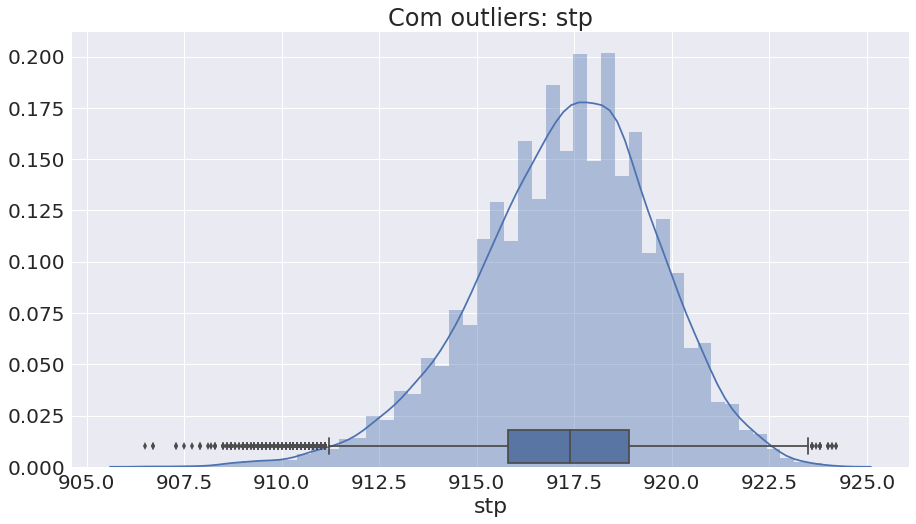

In [27]:
bp('stp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


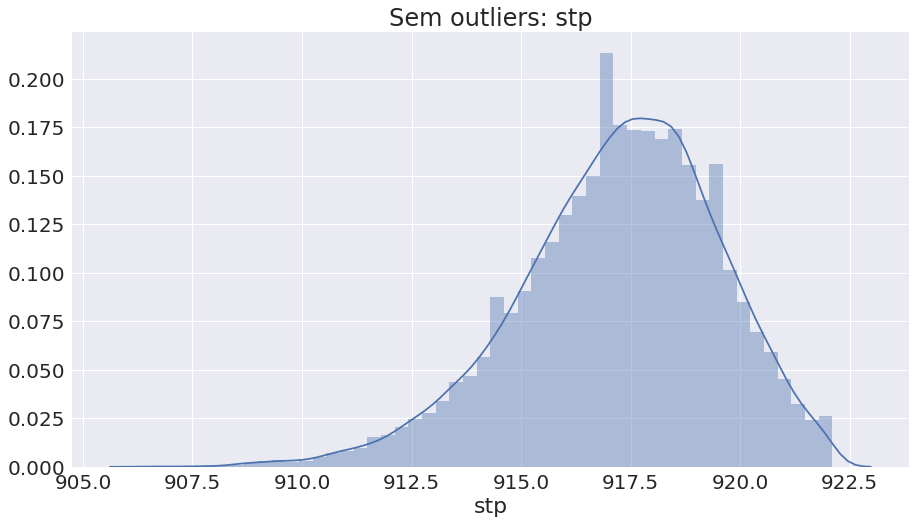

In [28]:
bp_sem('stp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


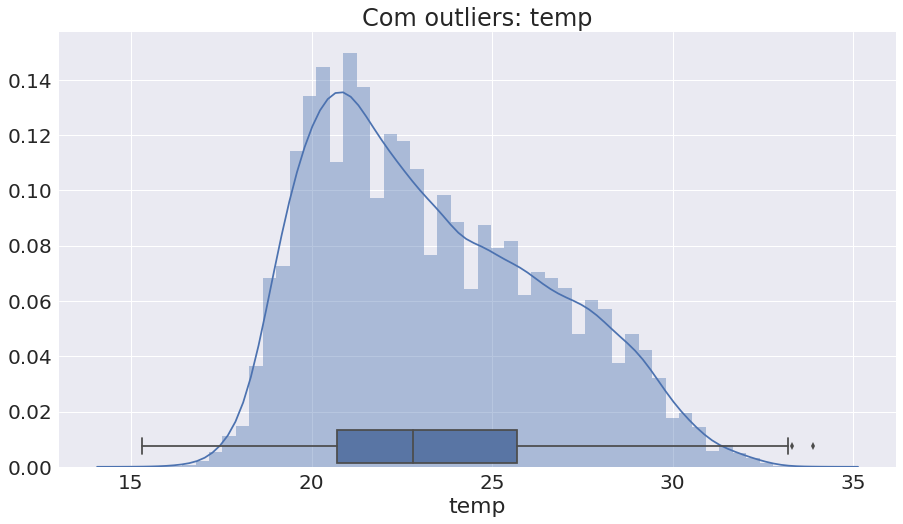

In [29]:
bp('temp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


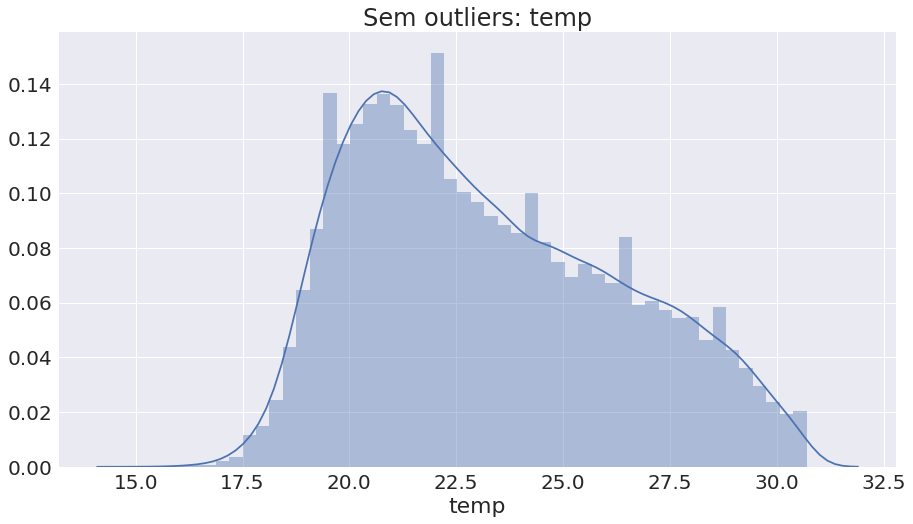

In [30]:
bp_sem('temp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


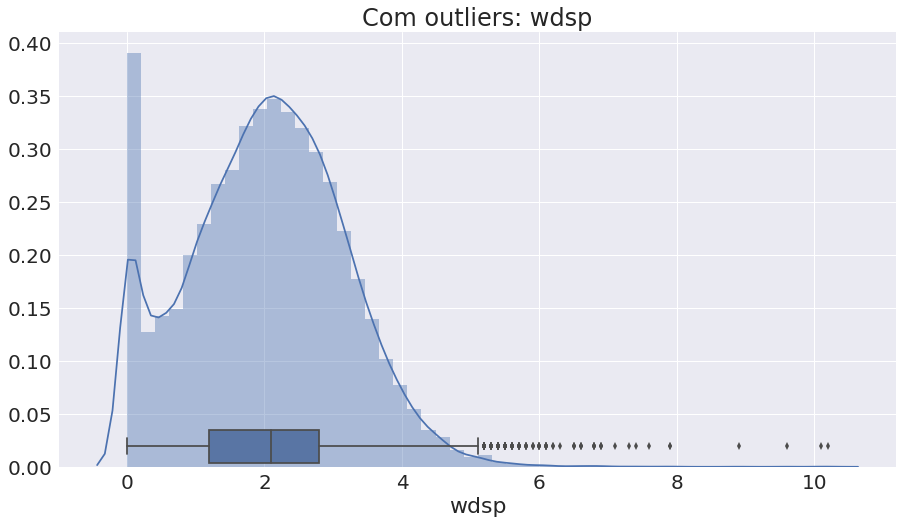

In [31]:
bp('wdsp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


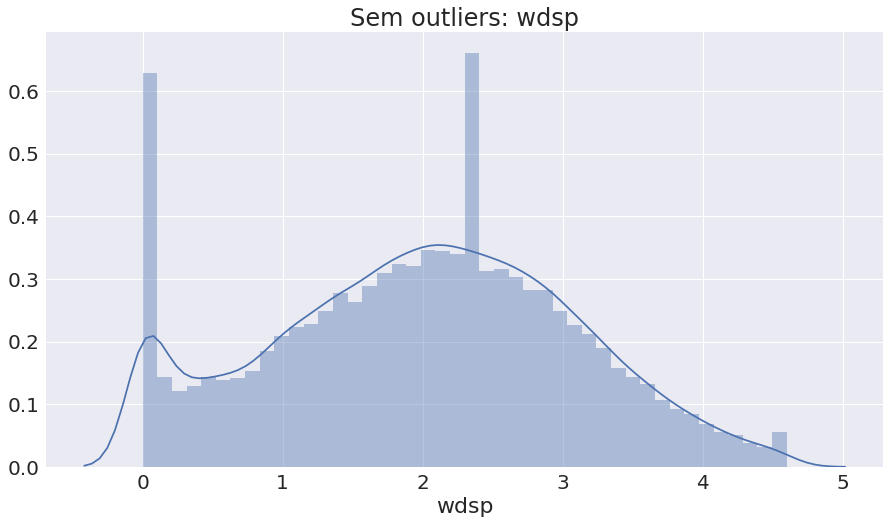

In [32]:
bp_sem('wdsp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


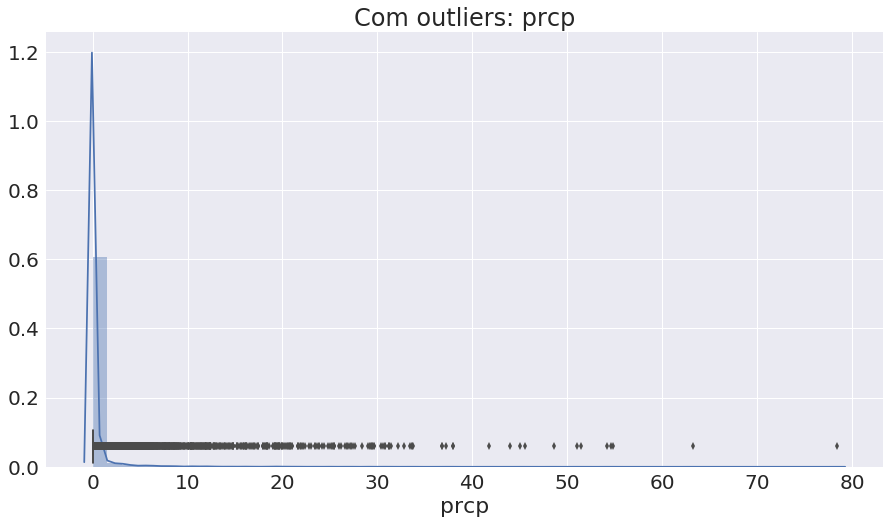

In [33]:
bp('prcp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


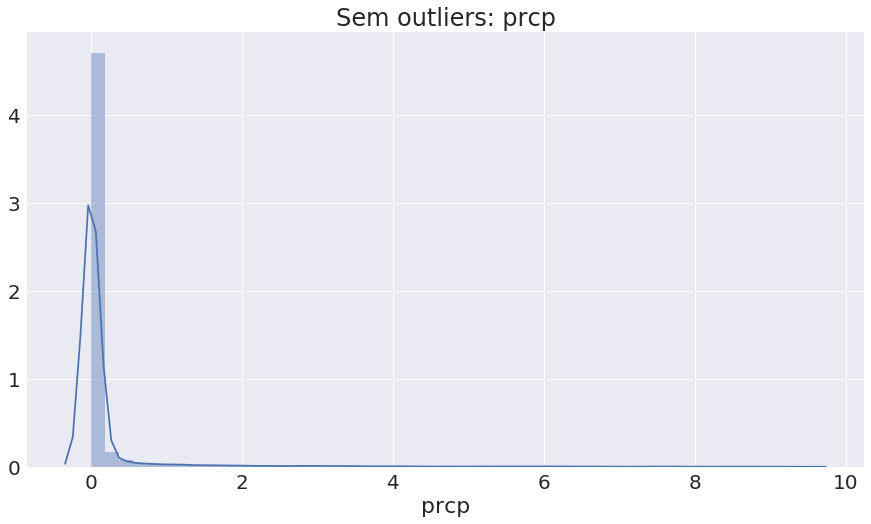

In [34]:
bp_sem('prcp')

<h3>Derivando novas variáveis (Feature engineering)</h3>

<p>Recuperando o backup do dataframe antes da limpeza dos nulos, pois preciso derivar as freatures primeiro.
Assim, após a derivá-las, irei apagar os que não pode ser nulo. Esta etapa teve que ser feita de novo, por este motivo</p> 

In [35]:
dfm = backup_df() 

In [36]:
len(dfm)

29112

In [37]:
dfm = dfm.drop('wdsp',1)
dfm = dfm.drop('wdct',1)
dfm = dfm.drop('gust',1)

<p>Conforme o Zarate orientou retirando o vento pois precisa ser modelado de forma diferente</p> 

In [38]:
CLEAN = ['wsnm','inme','city','prov','date']
REMOVE = ['yr', 'mo', 'da', 'hr']
#REMOVE = ['wsid','yr', 'mo', 'da', 'hr']
for v in CLEAN + REMOVE:
    dfm = dfm.drop(v,1)
dfm.sample(5)  

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin
835671,329,854.0,-19.883945,-43.969397,2013-01-28 15:00:00,12.8,919.7,919.9,919.6,21.7,19.3,22.8,19.4,20.4,17.2,87.0,87.0,76.0
834372,329,854.0,-19.883945,-43.969397,2012-12-05 12:00:00,0.0,919.8,919.8,919.6,24.6,15.2,24.9,15.5,23.3,14.3,56.0,59.0,53.0
836882,329,854.0,-19.883945,-43.969397,2013-03-20 02:00:00,0.0,919.4,919.5,919.3,19.5,13.4,19.9,13.7,19.5,13.4,68.0,68.0,67.0
822256,329,854.0,-19.883945,-43.969397,2008-03-16 16:00:00,0.0,920.2,921.2,920.2,24.9,19.2,25.1,19.7,23.3,17.6,71.0,76.0,66.0
841119,329,854.0,-19.883945,-43.969397,2015-01-13 15:00:00,0.0,919.3,919.8,919.3,30.0,13.1,31.6,15.2,29.6,12.8,36.0,40.0,34.0


In [39]:
ws = dfm['wsid'].groupby(dfm['wsid']).count()
ws = list(ws.keys())
print (ws)

[329]


In [40]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    
    if not lag:
        return df
    
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
  
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
        
    return df

In [41]:
NON_DER = ['wsid','elvt','lat', 'lon', 'yr', 'mo', 'da', 'hr']

dfr = df_derived_by_shift(dfm,24,NON_DER)

In [42]:
dfr.head(4)

var = []
cld = list(dfr.columns)
for x in cld:
    if len(x.split('_')) >= 2:
        var.append((x.split('_')[0], x.split('_')[1]))

In [43]:
cols = {}
for v,i in var:
    x = '{}_{}'.format(v, i)
    if int(i) not in cols:
        cols[int(i)] = [x]
    else:
        cols[int(i)].append(x)
#print cols

In [44]:
xxx = dfr.copy()

In [45]:
# Inicializando
xxx['prcp_acum_24'] = 99.99
xxx['prcp_plus_12'] = 99.99

In [46]:
for w in ws:
    
    size = xxx.loc[xxx['wsid'].isin([w])].iloc[:]['prcp'].count()
    
    pos_prcp = xxx.columns.get_loc('prcp')
    
    pos_acum_6 = xxx.columns.get_loc('prcp_acum_24')
    pos_plus_1 = xxx.columns.get_loc('prcp_plus_12')
    
    j=11
    
    for i in range(0,size):
        idx = xxx.loc[xxx['wsid'].isin([w])].index
        xxx.loc[xxx.loc[idx,'prcp_acum_24'].index[i],'prcp_acum_24'] = xxx.loc[xxx['wsid'].isin([w])].iloc[i:i+24,pos_prcp].sum()
        if i+12 < size:
            xxx.loc[xxx.loc[idx,'prcp_plus_12'].index[i],'prcp_plus_12'] = xxx.loc[xxx['wsid'].isin([w])].iloc[i:i+12,pos_prcp].sum()
        else:
            xxx.loc[xxx.loc[idx,'prcp_plus_12'].index[i],'prcp_plus_12']  = xxx.loc[xxx['wsid'].isin([w])].iloc[i:i+j,pos_prcp].sum()
            j-=1

In [47]:
dfr = xxx 

In [48]:
dfr.head(12)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24,prcp_acum_24,prcp_plus_12
816792,329,854.0,-19.883945,-43.969397,2006-12-01 00:00:00,0.0,915.4,915.4,914.0,20.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.8,15.2
816793,329,854.0,-19.883945,-43.969397,2006-12-01 01:00:00,0.0,916.0,916.0,915.4,20.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.8,15.2
816794,329,854.0,-19.883945,-43.969397,2006-12-01 02:00:00,0.4,916.0,916.2,916.0,20.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.2,15.4
816795,329,854.0,-19.883945,-43.969397,2006-12-01 03:00:00,1.8,915.1,916.0,915.1,20.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.8,15.0
816796,329,854.0,-19.883945,-43.969397,2006-12-01 04:00:00,12.4,914.4,915.2,914.4,20.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.2,13.6
816797,329,854.0,-19.883945,-43.969397,2006-12-01 05:00:00,0.6,913.8,914.4,913.8,20.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8,1.2
816798,329,854.0,-19.883945,-43.969397,2006-12-01 06:00:00,0.0,913.5,913.8,913.4,20.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,0.6
816799,329,854.0,-19.883945,-43.969397,2006-12-01 07:00:00,0.0,913.4,913.6,913.4,20.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,0.6
816800,329,854.0,-19.883945,-43.969397,2006-12-01 08:00:00,0.0,914.2,914.2,913.4,20.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,0.6
816801,329,854.0,-19.883945,-43.969397,2006-12-01 09:00:00,0.0,915.0,915.0,914.2,20.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.6,0.6


In [49]:
dfr.columns

Index(['wsid', 'elvt', 'lat', 'lon', 'mdct', 'prcp', 'stp', 'smax', 'smin',
       'temp',
       ...
       'dmax_17', 'dmax_18', 'dmax_19', 'dmax_20', 'dmax_21', 'dmax_22',
       'dmax_23', 'dmax_24', 'prcp_acum_24', 'prcp_plus_12'],
      dtype='object', length=356)

In [50]:
dfm = dfr

In [51]:
list(dfm.columns)

['wsid',
 'elvt',
 'lat',
 'lon',
 'mdct',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'tmin_7',
 'tmin_8',
 'tmin_9',
 'tmin_10',
 'tmin_11',
 'tmin_12',
 'tmin_13',
 'tmin_14',
 'tmin_15',
 'tmin_16',
 'tmin_17',
 'tmin_18',
 'tmin_19',
 'tmin_20',
 'tmin_21',
 'tmin_22',
 'tmin_23',
 'tmin_24',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'temp_7',
 'temp_8',
 'temp_9',
 'temp_10',
 'temp_11',
 'temp_12',
 'temp_13',
 'temp_14',
 'temp_15',
 'temp_16',
 'temp_17',
 'temp_18',
 'temp_19',
 'temp_20',
 'temp_21',
 'temp_22',
 'temp_23',
 'temp_24',
 'stp_1',
 'stp_2',
 'stp_3',
 'stp_4',
 'stp_5',
 'stp_6',
 'stp_7',
 'stp_8',
 'stp_9',
 'stp_10',
 'stp_11',
 'stp_12',
 'stp_13',
 'stp_14',
 'stp_15',
 'stp_16',
 'stp_17',
 'stp_18',
 'stp_19',
 'stp_20',
 'stp_21',
 'stp_22',
 'stp_23',
 'stp_24',
 'mdct_1',
 'mdct_2',
 'mdct

In [52]:
len(dfm)

29112

<h3>Preparando a base</h3>

<p>Removendo registros que não pode ser nulos e prejudicariam o treinamento</p>

In [53]:
cols = list(df.columns)
for v in ['wdsp','wdct','gust']:
    cols.remove(v)

In [54]:
COLS_BE_NULL = ['prcp'] + DES + ['temp']
for v in COLS_BE_NULL:
    if v in cols:
        cols.remove(v)
cols

['stp',
 'smax',
 'smin',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin']

In [55]:
dfm[cols] = dfm[cols].replace({0.0:np.nan}) 

In [56]:
print (len(dfm))
dfm  = dfm.dropna()
print (len(dfm))

29112
27721


In [57]:
dfm = dfm.reset_index(drop=True)

In [58]:
dfm.head(5)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24,prcp_acum_24,prcp_plus_12
0,329,854.0,-19.883945,-43.969397,2006-12-02 00:00:00,0.0,918.2,918.2,917.5,18.8,...,20.2,20.1,20.2,20.4,20.6,20.5,20.7,20.4,2.0,2.0
1,329,854.0,-19.883945,-43.969397,2006-12-02 01:00:00,0.4,918.7,918.7,918.2,18.6,...,19.9,20.2,20.1,20.2,20.4,20.6,20.5,20.7,2.0,2.0
2,329,854.0,-19.883945,-43.969397,2006-12-02 02:00:00,1.0,918.7,918.8,918.7,18.4,...,19.9,19.9,20.2,20.1,20.2,20.4,20.6,20.5,1.6,1.6
3,329,854.0,-19.883945,-43.969397,2006-12-02 03:00:00,0.2,918.1,918.7,918.1,18.6,...,20.6,19.9,19.9,20.2,20.1,20.2,20.4,20.6,0.6,0.6
4,329,854.0,-19.883945,-43.969397,2006-12-02 04:00:00,0.0,917.3,918.1,917.3,18.7,...,21.2,20.6,19.9,19.9,20.2,20.1,20.2,20.4,0.4,0.4


In [59]:
dfm = dfm.drop('wsid',1)
dfm = dfm.drop('mdct',1)

In [60]:
list(dfm.columns)

['elvt',
 'lat',
 'lon',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'tmin_7',
 'tmin_8',
 'tmin_9',
 'tmin_10',
 'tmin_11',
 'tmin_12',
 'tmin_13',
 'tmin_14',
 'tmin_15',
 'tmin_16',
 'tmin_17',
 'tmin_18',
 'tmin_19',
 'tmin_20',
 'tmin_21',
 'tmin_22',
 'tmin_23',
 'tmin_24',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'temp_7',
 'temp_8',
 'temp_9',
 'temp_10',
 'temp_11',
 'temp_12',
 'temp_13',
 'temp_14',
 'temp_15',
 'temp_16',
 'temp_17',
 'temp_18',
 'temp_19',
 'temp_20',
 'temp_21',
 'temp_22',
 'temp_23',
 'temp_24',
 'stp_1',
 'stp_2',
 'stp_3',
 'stp_4',
 'stp_5',
 'stp_6',
 'stp_7',
 'stp_8',
 'stp_9',
 'stp_10',
 'stp_11',
 'stp_12',
 'stp_13',
 'stp_14',
 'stp_15',
 'stp_16',
 'stp_17',
 'stp_18',
 'stp_19',
 'stp_20',
 'stp_21',
 'stp_22',
 'stp_23',
 'stp_24',
 'mdct_1',
 'mdct_2',
 'mdct_3',
 'mdct_4',
 '

In [61]:
REMOVE = ['mdct']
for i in range(1,25):
    REMOVE.append('mdct_'+str(i))
print (REMOVE)
for v in REMOVE:
    if v in list(dfm.columns):
        dfm = dfm.drop(v,1)

['mdct', 'mdct_1', 'mdct_2', 'mdct_3', 'mdct_4', 'mdct_5', 'mdct_6', 'mdct_7', 'mdct_8', 'mdct_9', 'mdct_10', 'mdct_11', 'mdct_12', 'mdct_13', 'mdct_14', 'mdct_15', 'mdct_16', 'mdct_17', 'mdct_18', 'mdct_19', 'mdct_20', 'mdct_21', 'mdct_22', 'mdct_23', 'mdct_24']


In [62]:
list(dfm.columns)

['elvt',
 'lat',
 'lon',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'tmin_7',
 'tmin_8',
 'tmin_9',
 'tmin_10',
 'tmin_11',
 'tmin_12',
 'tmin_13',
 'tmin_14',
 'tmin_15',
 'tmin_16',
 'tmin_17',
 'tmin_18',
 'tmin_19',
 'tmin_20',
 'tmin_21',
 'tmin_22',
 'tmin_23',
 'tmin_24',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'temp_7',
 'temp_8',
 'temp_9',
 'temp_10',
 'temp_11',
 'temp_12',
 'temp_13',
 'temp_14',
 'temp_15',
 'temp_16',
 'temp_17',
 'temp_18',
 'temp_19',
 'temp_20',
 'temp_21',
 'temp_22',
 'temp_23',
 'temp_24',
 'stp_1',
 'stp_2',
 'stp_3',
 'stp_4',
 'stp_5',
 'stp_6',
 'stp_7',
 'stp_8',
 'stp_9',
 'stp_10',
 'stp_11',
 'stp_12',
 'stp_13',
 'stp_14',
 'stp_15',
 'stp_16',
 'stp_17',
 'stp_18',
 'stp_19',
 'stp_20',
 'stp_21',
 'stp_22',
 'stp_23',
 'stp_24',
 'dewp_1',
 'dewp_2',
 'dewp_3',
 'dewp_4',
 '

In [63]:
#como esta rede é especifica para a BH, vamos remover elvt, lat, lon
REMOVE = ['elvt','lat', 'lon']
for v in REMOVE:
    dfm = dfm.drop(v,1)

In [64]:
#dfm = dfm.drop('wsid',1)
#dfm

In [65]:
#dfm.loc[28807,'prcp_plus_1'] = 0.0
#x = dfm[dfm['prcp_plus_1']==99.99]
#x

In [66]:
dfm.to_csv('../data/derivaded_3.csv')

<h2>Mineiração dos dados</h2>

<h3>Rede neural</h3>

In [67]:
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error
from sklearn.model_selection import train_test_split 

In [68]:
target = 'prcp_plus_12'

In [69]:
X = dfm[[col for col in dfm.columns]]
y = dfm[target]

<p>Separando o conjunto de treinamento e validação (metade dos 10% separados para validação)</p>

In [70]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.1, random_state=12) 
print (len(X_train))
print (len(X_tmp))

24948
2773


<p>Separando o conjunto de testes</p>

In [71]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.2)

In [72]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))  

Training instances   24948, Training features   327
Validation instances 555, Validation features 327
Testing instances    2218, Testing features    327


In [73]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
sd_units = X_train.shape[1] 
#activation_fn = tf.sigmoid
batch_size = 1000
up = int(len(X_train)/batch_size)

In [74]:
Z = X.copy()
Z.pop(target)
Z.pop('prcp_acum_24')
feature_cols = [tf.feature_column.numeric_column(col) for col in Z.columns] 

In [75]:
feature_cols

[_NumericColumn(key='prcp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='stp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='smax', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='smin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='temp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='tmax', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='tmin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dewp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dmax', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dmin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericCo

In [76]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols
                                      ,hidden_units=[st_units,sd_units]
                                      #,activation_fn=activation_fn
                                      ,model_dir='/tmp/tf_model_09')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_global_id_in_cluster': 0, '_model_dir': '/tmp/tf_model_09', '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_save_checkpoints_steps': None, '_session_config': None, '_save_summary_steps': 100, '_log_step_count_steps': 100, '_num_ps_replicas': 0, '_task_id': 0, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': None, '_num_worker_replicas': 1, '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9ef5866cc0>, '_service': None}


In [77]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=batch_size):      
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [78]:
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(return_indices=True)

In [79]:
X_train

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24,prcp_acum_24,prcp_plus_12
12778,0.0,914.6,915.0,914.6,19.2,17.8,20.1,18.6,18.9,17.5,...,20.6,18.9,18.7,18.6,18.4,18.6,18.3,18.6,13.8,13.2
15604,0.0,917.2,917.7,917.1,22.6,12.7,23.3,12.7,22.6,12.6,...,22.0,20.6,20.6,20.9,21.2,21.5,21.7,22.0,0.0,0.0
16763,0.0,917.6,917.9,917.6,22.2,14.7,23.2,14.8,22.1,14.5,...,24.5,23.9,22.7,22.2,22.4,23.2,23.7,23.6,0.0,0.0
6798,0.0,915.8,915.8,914.8,23.4,17.7,25.8,17.8,23.4,16.8,...,21.2,21.3,21.4,22.2,22.4,22.7,23.2,24.2,0.0,0.0
17755,0.0,918.7,918.8,918.6,26.4,17.4,26.5,18.4,24.6,15.9,...,18.4,25.0,25.7,24.2,23.5,25.2,26.1,25.7,0.0,0.0
1422,0.0,922.4,923.4,922.4,27.3,17.2,28.6,17.7,26.9,15.2,...,24.6,25.9,26.9,27.3,27.4,27.5,26.2,25.5,0.0,0.0
8464,0.8,912.8,912.8,912.5,20.3,19.4,20.4,19.5,20.2,19.4,...,23.8,22.2,21.5,20.7,20.4,19.8,19.6,19.6,50.8,43.4
24257,0.0,916.7,916.9,916.6,21.8,17.6,22.0,18.1,20.8,17.5,...,23.4,22.3,20.9,19.6,19.4,19.5,20.0,20.3,0.0,0.0
24981,0.0,917.6,917.6,916.5,22.5,18.7,22.5,19.3,20.8,18.4,...,27.9,27.4,27.1,25.6,24.4,22.3,20.2,19.7,2.2,0.0
27383,0.0,920.5,920.5,919.7,24.3,16.4,25.4,16.5,24.1,15.9,...,20.6,20.7,21.2,22.1,22.9,22.7,22.6,24.1,1.4,0.0


In [80]:
def balancear(_X, _y):
    
    def f(x):
        if x['prcp_acum_24'] == 0.0: 
            return 0
        elif x['prcp_acum_24'] <= 49.99:       
            return 1
        else:
            return 2        
        
    #Balancear considerando apenas com chuva e sem chuva.    
    _X['rain'] = _X.apply(f,axis=1) 
    
    _X_resampled, _y_resampled, idx_resampled = under.fit_sample(_X, _X['rain'])
    
    _X = pd.DataFrame(_X_resampled, columns = _X.columns)
    _y = pd.DataFrame(_y_resampled, columns =['rain'])
    
    _y = _X['prcp_plus_12']
    
    _X = _X.drop('rain',1)
    _X = _X.drop('prcp_plus_12',1)
    _X = _X.drop('prcp_acum_24',1)
    
    return _X,_y

In [82]:
#X_val = X_val.drop('prcp_plus_12',1)
#X_val = X_val.drop('prcp_acum_24',1)

In [83]:
evaluations = []  
STEPS = 500  

for i in range(1, 200):    
    
    A, b = balancear(X_train.copy(), y_train.copy())
    
    print ('treinando agora...')
    
    regressor.train(input_fn=wx_input_fn(A ,b), steps=STEPS)
    
    evaluations.append(
        regressor.evaluate(input_fn=wx_input_fn(X_val
                                                ,y_val
                                                ,num_epochs=1
                                                ,shuffle=False)))

treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 1, loss = 16368400.0
INFO:tensorflow:global_step/sec: 2.98309
INFO:tensorflow:step = 101, loss = 236700.53 (33.523 sec)
INFO:tensorflow:global_step/sec: 3.04986
INFO:tensorflow:step = 201, loss = 311183.94 (32.789 sec)
INFO:tensorflow:global_step/sec: 3.09092
INFO:tensorflow:step = 301, loss = 785035.0 (32.355 sec)
INFO:tensorflow:global_step/sec: 3.02536
INFO:tensorflow:step = 401, loss = 676952.6 (33.052 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 812140.56.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluati

INFO:tensorflow:Loss for final step: 230856.56.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-13:30:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-13:30:49
INFO:tensorflow:Saving dict for global step 3000: average_loss = 254.71619, global_step = 3000, loss = 141367.48
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3001 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 3001, loss = 88173.19

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 5501 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 5501, loss = 701734.6
INFO:tensorflow:global_step/sec: 3.33066
INFO:tensorflow:step = 5601, loss = 611425.9 (30.025 sec)
INFO:tensorflow:global_step/sec: 3.40016
INFO:tensorflow:step = 5701, loss = 496164.8 (29.411 sec)
INFO:tensorflow:global_step/sec: 3.34321
INFO:tensorflow:step = 5801, loss = 160932.1 (29.911 sec)
INFO:tensorflow:global_step/sec: 3.2998
INFO:tensorflow:step = 5901, loss = 386965.3 (30.305 sec)
INFO:tensorflow:Saving checkpoints for 6000 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 314266.3.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-13:47:22
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-6000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running l

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-8500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-14:00:54
INFO:tensorflow:Saving dict for global step 8500: average_loss = 256.62988, global_step = 8500, loss = 142429.58
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-8500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 8501 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 8501, loss = 972789.75
INFO:tensorflow:global_step/sec: 3.2973
INFO:tensorflow:step = 8601, loss = 468740.4 (30.329 sec)
INFO:tensorflow:global_step/sec: 3.27444
INFO:tensorflow:step = 8701, loss = 198

INFO:tensorflow:global_step/sec: 3.32182
INFO:tensorflow:step = 11101, loss = 262338.94 (30.106 sec)
INFO:tensorflow:global_step/sec: 3.32348
INFO:tensorflow:step = 11201, loss = 232078.5 (30.090 sec)
INFO:tensorflow:global_step/sec: 3.29705
INFO:tensorflow:step = 11301, loss = 641028.5 (30.328 sec)
INFO:tensorflow:global_step/sec: 3.33078
INFO:tensorflow:step = 11401, loss = 757804.1 (30.023 sec)
INFO:tensorflow:Saving checkpoints for 11500 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 862143.1.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-14:17:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-11500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-14:17:11
INFO:tensorflow:Saving dict for global step 11500: average_loss = 593.1138, global_ste

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-14:30:37
INFO:tensorflow:Saving dict for global step 14000: average_loss = 249.83665, global_step = 14000, loss = 138659.34
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 14001 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 14001, loss = 1003760.0
INFO:tensorflow:global_step/sec: 3.23166
INFO:tensorflow:step = 14101, loss = 507377.06 (30.944 sec)
INFO:tensorflow:global_step/sec: 3.34852
INFO:tensorflow:step = 14201, loss = 240831.12 (29.864 sec)
INFO:tensorflow:global_step/sec: 3.42382
INFO:tensorflow:step = 14301, loss = 36862

INFO:tensorflow:step = 16601, loss = 681290.94 (30.359 sec)
INFO:tensorflow:global_step/sec: 3.36271
INFO:tensorflow:step = 16701, loss = 495689.78 (29.738 sec)
INFO:tensorflow:global_step/sec: 3.38173
INFO:tensorflow:step = 16801, loss = 306811.2 (29.571 sec)
INFO:tensorflow:global_step/sec: 3.35569
INFO:tensorflow:step = 16901, loss = 248237.06 (29.800 sec)
INFO:tensorflow:Saving checkpoints for 17000 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 191186.28.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-14:46:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-17000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-14:46:50
INFO:tensorflow:Saving dict for global step 17000: average_loss = 252.191, global_step = 17000, loss = 139966.0
treinando ag

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-15:00:18
INFO:tensorflow:Saving dict for global step 19500: average_loss = 247.55133, global_step = 19500, loss = 137390.98
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-19500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 19501 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 19501, loss = 531393.75
INFO:tensorflow:global_step/sec: 3.2899
INFO:tensorflow:step = 19601, loss = 795702.7 (30.398 sec)
INFO:tensorflow:global_step/sec: 3.32077
INFO:tensorflow:step = 19701, loss = 523041.62 (30.114 sec)
INFO:tensorflow:global_step/sec: 3.42059
INFO:tensorflow:step = 19801, loss = 264363.62 (29.235 sec)
INFO:tensorflow:global_

INFO:tensorflow:global_step/sec: 3.35993
INFO:tensorflow:step = 22201, loss = 406696.44 (29.763 sec)
INFO:tensorflow:global_step/sec: 3.31083
INFO:tensorflow:step = 22301, loss = 179647.48 (30.203 sec)
INFO:tensorflow:global_step/sec: 3.32729
INFO:tensorflow:step = 22401, loss = 386310.2 (30.055 sec)
INFO:tensorflow:Saving checkpoints for 22500 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 283999.06.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-15:16:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-22500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-15:16:29
INFO:tensorflow:Saving dict for global step 22500: average_loss = 247.16197, global_step = 22500, loss = 137174.89
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:

INFO:tensorflow:Finished evaluation at 2018-04-15-15:29:56
INFO:tensorflow:Saving dict for global step 25000: average_loss = 244.79741, global_step = 25000, loss = 135862.56
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-25000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 25001 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 25001, loss = 693426.7
INFO:tensorflow:global_step/sec: 3.27608
INFO:tensorflow:step = 25101, loss = 655854.0 (30.526 sec)
INFO:tensorflow:global_step/sec: 3.37008
INFO:tensorflow:step = 25201, loss = 471271.0 (29.673 sec)
INFO:tensorflow:global_step/sec: 3.40033
INFO:tensorflow:step = 25301, loss = 191391.05 (29.409 sec)
INFO:tensorflow:global_step/sec: 3.4408
INFO:tensorflow:step = 25401

INFO:tensorflow:step = 27701, loss = 458413.44 (29.400 sec)
INFO:tensorflow:global_step/sec: 3.35291
INFO:tensorflow:step = 27801, loss = 206173.0 (29.825 sec)
INFO:tensorflow:global_step/sec: 3.36773
INFO:tensorflow:step = 27901, loss = 341448.62 (29.693 sec)
INFO:tensorflow:Saving checkpoints for 28000 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 283688.94.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-15:46:09
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-28000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-15:46:11
INFO:tensorflow:Saving dict for global step 28000: average_loss = 243.45833, global_step = 28000, loss = 135119.38
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Cr

INFO:tensorflow:Saving dict for global step 30500: average_loss = 346.09058, global_step = 30500, loss = 192080.27
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-30500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 30501 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 30501, loss = 702591.5
INFO:tensorflow:global_step/sec: 3.29952
INFO:tensorflow:step = 30601, loss = 483107.9 (30.309 sec)
INFO:tensorflow:global_step/sec: 3.37464
INFO:tensorflow:step = 30701, loss = 185369.28 (29.633 sec)
INFO:tensorflow:global_step/sec: 3.32608
INFO:tensorflow:step = 30801, loss = 323289.75 (30.065 sec)
INFO:tensorflow:global_step/sec: 3.371
INFO:tensorflow:step = 30901, loss = 772621.0 (29.665 sec)
INFO:tensorflow:Saving check

INFO:tensorflow:global_step/sec: 3.36553
INFO:tensorflow:step = 33301, loss = 237123.86 (29.713 sec)
INFO:tensorflow:global_step/sec: 3.35537
INFO:tensorflow:step = 33401, loss = 645004.6 (29.803 sec)
INFO:tensorflow:Saving checkpoints for 33500 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 396738.7.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-16:15:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-33500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-16:15:54
INFO:tensorflow:Saving dict for global step 33500: average_loss = 256.32553, global_step = 33500, loss = 142260.67
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized

treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-36000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 36001 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 36001, loss = 348389.25
INFO:tensorflow:global_step/sec: 3.28004
INFO:tensorflow:step = 36101, loss = 162716.28 (30.489 sec)
INFO:tensorflow:global_step/sec: 3.36791
INFO:tensorflow:step = 36201, loss = 436532.62 (29.692 sec)
INFO:tensorflow:global_step/sec: 3.34495
INFO:tensorflow:step = 36301, loss = 778574.75 (29.895 sec)
INFO:tensorflow:global_step/sec: 3.3968
INFO:tensorflow:step = 36401, loss = 514190.03 (29.440 sec)
INFO:tensorflow:Saving checkpoints for 36500 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 589999.9.
INFO:tensorfl

INFO:tensorflow:global_step/sec: 3.38595
INFO:tensorflow:step = 38901, loss = 727193.6 (29.536 sec)
INFO:tensorflow:Saving checkpoints for 39000 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 711019.6.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-16:45:40
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-39000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-16:45:41
INFO:tensorflow:Saving dict for global step 39000: average_loss = 424.03598, global_step = 39000, loss = 235339.97
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-39000
INFO:tensorflow:Running

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-41500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 41501 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 41501, loss = 126792.984
INFO:tensorflow:global_step/sec: 3.29068
INFO:tensorflow:step = 41601, loss = 175234.6 (30.390 sec)
INFO:tensorflow:global_step/sec: 3.35204
INFO:tensorflow:step = 41701, loss = 415134.44 (29.833 sec)
INFO:tensorflow:global_step/sec: 3.33227
INFO:tensorflow:step = 41801, loss = 783043.75 (30.009 sec)
INFO:tensorflow:global_step/sec: 3.33268
INFO:tensorflow:step = 41901, loss = 533186.2 (30.006 sec)
INFO:tensorflow:Saving checkpoints for 42000 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 589454.7.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling mod

INFO:tensorflow:Saving checkpoints for 44500 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 234087.19.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-17:15:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-44500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-17:15:29
INFO:tensorflow:Saving dict for global step 44500: average_loss = 238.49718, global_step = 44500, loss = 132365.94
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-44500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-47000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 47001 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 47001, loss = 856920.0
INFO:tensorflow:global_step/sec: 3.24851
INFO:tensorflow:step = 47101, loss = 488302.12 (30.785 sec)
INFO:tensorflow:global_step/sec: 3.31223
INFO:tensorflow:step = 47201, loss = 301165.5 (30.191 sec)
INFO:tensorflow:global_step/sec: 3.39489
INFO:tensorflow:step = 47301, loss = 233118.19 (29.456 sec)
INFO:tensorflow:global_step/sec: 3.40467
INFO:tensorflow:step = 47401, loss = 567621.9 (29.372 sec)
INFO:tensorflow:Saving checkpoints for 47500 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 391774.6.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-17:31:43
INFO:tensorflow:Gra

INFO:tensorflow:Loss for final step: 221701.81.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-17:45:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-17:45:19
INFO:tensorflow:Saving dict for global step 50000: average_loss = 238.14, global_step = 50000, loss = 132167.7
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 50001 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 50001, loss = 305141

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 52501 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 52501, loss = 332717.03
INFO:tensorflow:global_step/sec: 3.29914
INFO:tensorflow:step = 52601, loss = 662681.4 (30.312 sec)
INFO:tensorflow:global_step/sec: 3.37608
INFO:tensorflow:step = 52701, loss = 621145.1 (29.620 sec)
INFO:tensorflow:global_step/sec: 3.36303
INFO:tensorflow:step = 52801, loss = 410334.7 (29.735 sec)
INFO:tensorflow:global_step/sec: 3.26076
INFO:tensorflow:step = 52901, loss = 176042.12 (30.667 sec)
INFO:tensorflow:Saving checkpoints for 53000 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 241424.94.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-18:01:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-53000
INFO:tensorflow:Ru

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-18:15:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-55500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-18:15:02
INFO:tensorflow:Saving dict for global step 55500: average_loss = 371.94424, global_step = 55500, loss = 206429.06
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-55500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 55501 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 55501, loss = 622248.8
INFO:tensorflow:global_step/sec: 3.3472
INFO:tensorflow:step = 55601, loss 

INFO:tensorflow:Saving checkpoints for 58001 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 58001, loss = 770969.0
INFO:tensorflow:global_step/sec: 3.33229
INFO:tensorflow:step = 58101, loss = 374582.62 (30.011 sec)
INFO:tensorflow:global_step/sec: 3.40471
INFO:tensorflow:step = 58201, loss = 202561.12 (29.371 sec)
INFO:tensorflow:global_step/sec: 3.28277
INFO:tensorflow:step = 58301, loss = 331485.7 (30.462 sec)
INFO:tensorflow:global_step/sec: 3.3373
INFO:tensorflow:step = 58401, loss = 760889.2 (29.965 sec)
INFO:tensorflow:Saving checkpoints for 58500 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 672025.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-18:31:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-58500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Fini

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-61000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-18:44:48
INFO:tensorflow:Saving dict for global step 61000: average_loss = 239.69026, global_step = 61000, loss = 133028.1
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-61000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 61001 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 61001, loss = 790072.7
INFO:tensorflow:global_step/sec: 3.37752
INFO:tensorflow:step = 61101, loss = 445106.0 (29.609 sec)
INFO:tensorflow:global_step/sec: 3.40743
INFO:tensorflow:step = 61201, los

INFO:tensorflow:step = 63501, loss = 786579.7
INFO:tensorflow:global_step/sec: 3.3423
INFO:tensorflow:step = 63601, loss = 550164.3 (29.921 sec)
INFO:tensorflow:global_step/sec: 3.33135
INFO:tensorflow:step = 63701, loss = 388445.3 (30.018 sec)
INFO:tensorflow:global_step/sec: 3.31304
INFO:tensorflow:step = 63801, loss = 188830.23 (30.183 sec)
INFO:tensorflow:global_step/sec: 3.32056
INFO:tensorflow:step = 63901, loss = 341432.3 (30.116 sec)
INFO:tensorflow:Saving checkpoints for 64000 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 307493.47.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-19:00:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-64000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-19:01:01
INFO:tensorflow:Saving dict for global s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-19:14:34
INFO:tensorflow:Saving dict for global step 66500: average_loss = 438.3553, global_step = 66500, loss = 243287.19
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-66500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 66501 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 66501, loss = 445924.94
INFO:tensorflow:global_step/sec: 3.34431
INFO:tensorflow:step = 66601, loss = 672169.25 (29.903 sec)
INFO:tensorflow:global_step/sec: 3.40122
INFO:tensorflow:step = 66701, loss = 650891.6 (29.401 sec)
INFO:tensorflow:global_step/sec: 3.39157
INFO:tensorflow:step = 66801, loss = 466821.

INFO:tensorflow:step = 69101, loss = 430602.75 (29.854 sec)
INFO:tensorflow:global_step/sec: 3.40834
INFO:tensorflow:step = 69201, loss = 275342.0 (29.340 sec)
INFO:tensorflow:global_step/sec: 3.33251
INFO:tensorflow:step = 69301, loss = 255443.88 (30.007 sec)
INFO:tensorflow:global_step/sec: 3.3619
INFO:tensorflow:step = 69401, loss = 682134.5 (29.745 sec)
INFO:tensorflow:Saving checkpoints for 69500 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 550059.75.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-19:30:40
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-69500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-19:30:42
INFO:tensorflow:Saving dict for global step 69500: average_loss = 287.76782, global_step = 69500, loss = 159711.14
treinando a

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-19:44:14
INFO:tensorflow:Saving dict for global step 72000: average_loss = 362.5753, global_step = 72000, loss = 201229.28
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-72000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 72001 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 72001, loss = 602123.6
INFO:tensorflow:global_step/sec: 3.33365
INFO:tensorflow:step = 72101, loss = 651169.6 (29.998 sec)
INFO:tensorflow:global_step/sec: 3.40276
INFO:tensorflow:step = 72201, loss = 421864.94 (29.388 sec)
INFO:tensorflow:global_step/sec: 3.4825
INFO:tensorflow:step = 72301, loss = 201977.81 (28.716 sec)
INFO:tensorflow:global_st

INFO:tensorflow:global_step/sec: 3.40555
INFO:tensorflow:step = 74701, loss = 472347.03 (29.364 sec)
INFO:tensorflow:global_step/sec: 3.32851
INFO:tensorflow:step = 74801, loss = 263069.9 (30.044 sec)
INFO:tensorflow:global_step/sec: 3.34795
INFO:tensorflow:step = 74901, loss = 199382.62 (29.869 sec)
INFO:tensorflow:Saving checkpoints for 75000 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 157905.53.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-20:00:25
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-75000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-20:00:27
INFO:tensorflow:Saving dict for global step 75000: average_loss = 235.98412, global_step = 75000, loss = 130971.19
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:

INFO:tensorflow:Finished evaluation at 2018-04-15-20:13:55
INFO:tensorflow:Saving dict for global step 77500: average_loss = 233.93176, global_step = 77500, loss = 129832.125
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-77500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 77501 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 77501, loss = 735355.06
INFO:tensorflow:global_step/sec: 3.36637
INFO:tensorflow:step = 77601, loss = 303404.8 (29.707 sec)
INFO:tensorflow:global_step/sec: 3.377
INFO:tensorflow:step = 77701, loss = 204967.53 (29.613 sec)
INFO:tensorflow:global_step/sec: 3.37837
INFO:tensorflow:step = 77801, loss = 471031.88 (29.600 sec)
INFO:tensorflow:global_step/sec: 3.28089
INFO:tensorflow:step = 779

INFO:tensorflow:step = 80201, loss = 505319.16 (29.730 sec)
INFO:tensorflow:global_step/sec: 3.34887
INFO:tensorflow:step = 80301, loss = 301812.38 (29.861 sec)
INFO:tensorflow:global_step/sec: 3.36839
INFO:tensorflow:step = 80401, loss = 192496.61 (29.688 sec)
INFO:tensorflow:Saving checkpoints for 80500 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 196919.69.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-20:30:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-80500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-20:30:11
INFO:tensorflow:Saving dict for global step 80500: average_loss = 233.89789, global_step = 80500, loss = 129813.33
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:C

INFO:tensorflow:Saving dict for global step 83000: average_loss = 395.8094, global_step = 83000, loss = 219674.2
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-83000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 83001 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 83001, loss = 227753.75
INFO:tensorflow:global_step/sec: 3.32286
INFO:tensorflow:step = 83101, loss = 175450.16 (30.096 sec)
INFO:tensorflow:global_step/sec: 3.35877
INFO:tensorflow:step = 83201, loss = 472213.62 (29.773 sec)
INFO:tensorflow:global_step/sec: 3.31116
INFO:tensorflow:step = 83301, loss = 754717.1 (30.201 sec)
INFO:tensorflow:global_step/sec: 3.35038
INFO:tensorflow:step = 83401, loss = 445509.94 (29.848 sec)
INFO:tensorflow:Saving che

INFO:tensorflow:global_step/sec: 3.3691
INFO:tensorflow:step = 85801, loss = 464145.3 (29.682 sec)
INFO:tensorflow:global_step/sec: 3.33342
INFO:tensorflow:step = 85901, loss = 241144.88 (29.999 sec)
INFO:tensorflow:Saving checkpoints for 86000 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 316274.06.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-20:59:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-86000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-20:59:55
INFO:tensorflow:Saving dict for global step 86000: average_loss = 231.92319, global_step = 86000, loss = 128717.37
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized

treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-88500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 88501 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 88501, loss = 892641.25
INFO:tensorflow:global_step/sec: 3.3356
INFO:tensorflow:step = 88601, loss = 375146.53 (29.981 sec)
INFO:tensorflow:global_step/sec: 3.42321
INFO:tensorflow:step = 88701, loss = 228483.45 (29.213 sec)
INFO:tensorflow:global_step/sec: 3.35287
INFO:tensorflow:step = 88801, loss = 324727.03 (29.825 sec)
INFO:tensorflow:global_step/sec: 3.31412
INFO:tensorflow:step = 88901, loss = 681309.5 (30.174 sec)
INFO:tensorflow:Saving checkpoints for 89000 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 664579.2.
INFO:tensorflo

INFO:tensorflow:global_step/sec: 3.34202
INFO:tensorflow:step = 91401, loss = 786985.25 (29.922 sec)
INFO:tensorflow:Saving checkpoints for 91500 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 764834.44.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-21:29:38
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-91500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-21:29:39
INFO:tensorflow:Saving dict for global step 91500: average_loss = 400.94714, global_step = 91500, loss = 222525.66
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-91500
INFO:tensorflow:Runni

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-94000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 94001 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:step = 94001, loss = 818313.8
INFO:tensorflow:global_step/sec: 3.32571
INFO:tensorflow:step = 94101, loss = 340493.03 (30.070 sec)
INFO:tensorflow:global_step/sec: 3.29482
INFO:tensorflow:step = 94201, loss = 198015.06 (30.351 sec)
INFO:tensorflow:global_step/sec: 3.35492
INFO:tensorflow:step = 94301, loss = 332331.62 (29.806 sec)
INFO:tensorflow:global_step/sec: 3.41965
INFO:tensorflow:step = 94401, loss = 765352.25 (29.243 sec)
INFO:tensorflow:Saving checkpoints for 94500 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 725968.25.
INFO:tensorflow:Calling model_f

INFO:tensorflow:step = 96901, loss = 242976.77 (29.542 sec)
INFO:tensorflow:Saving checkpoints for 97000 into /tmp/tf_model_09/model.ckpt.
INFO:tensorflow:Loss for final step: 291580.2.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-21:59:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-97000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-21:59:25
INFO:tensorflow:Saving dict for global step 97000: average_loss = 235.9447, global_step = 97000, loss = 130949.31
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-97000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done runn

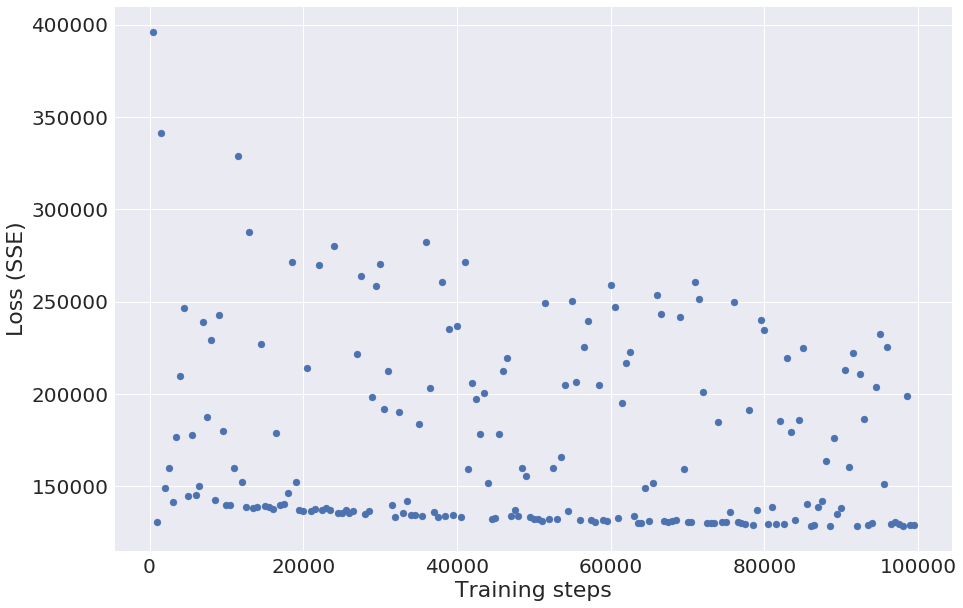

In [84]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [85]:
X_test = X_test.drop('prcp_plus_12',1)
X_test = X_test.drop('prcp_acum_24',1)

In [86]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,  
                                              num_epochs=1,
                                              shuffle=False))

predictions = np.array([p['predictions'][0] for p in pred])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_09/model.ckpt-99500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [87]:

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f " % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f " % median_absolute_error(  
                                            y_test, predictions))

The Explained Variance: -0.05
The Mean Absolute Error: 8.62 
The Median Absolute Error: 6.49 


In [88]:
predictions

array([ 19.523119,  22.847906, -10.542124, ...,  17.853682,   2.088949,
       -13.499895], dtype=float32)

In [89]:
predictions.size

2218

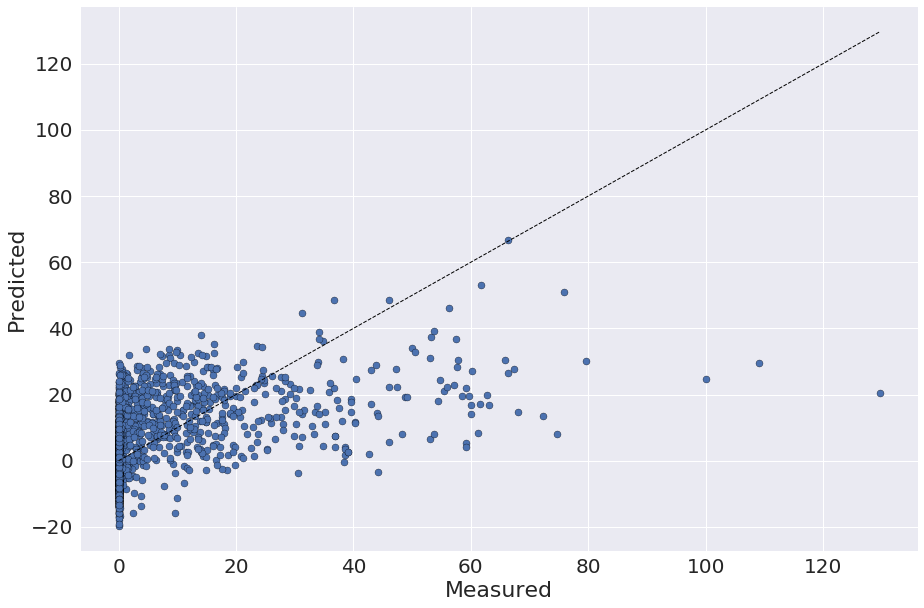

In [90]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()